In [1]:
%%time
import praw
import datetime
import numpy as np
import pandas as pd

Wall time: 2.05 s


In [2]:
import praw

reddit = praw.Reddit(client_id='S7KAJs3nVTIVSA',
                     client_secret='1q9mp08dEhzOSPXqHqtu16M6OZo',
                     user_agent='WPComp:v1.0 (by /u/TheArch-Man)')

print(reddit.read_only)

True


In [3]:
master = praw.models.Submission(reddit, id = "d7wqms").comments
post = praw.models.Submission(reddit, id = "d7wqms")

In [4]:
class User:
    def __init__(self, name):
        self.name = name
        self.hasVoted = False
        self.points = 0
        self.pointHist = [0]

class Group:
    def __init__(self, title):
        self.alphas = ["A", "B", "C", "D", "E", "F", "G", "H"]
        self.names = []
        self.name = title
        loc = self.alphas.index(title)
        if loc == len(self.alphas) - 1:
            self.voteFor = self.alphas[0]
        else:
            self.voteFor = self.alphas[loc+1]

class Vote:
    def __init__(self, fp, sp, tp, forG, fromG, user, cuc):
        if fp == "zebulonworkshops":
            fp = "zebulonworkshop"
        if sp == "zebulonworkshops":
            sp = "zebulonworkshop"
        if tp == "zebulonworkshops":
            tp = "zebulonworkshop"
        self.first = fp
        self.second = sp
        self.third = tp
        self.forGroup = forG
        self.fromG = fromG
        self.author = user
        self.birth = cuc
    
    def toString(self):
        print("1st: ", self.first)
        print("2nd: ", self.second)
        print("3rd: ", self.third)
        print("By ", self.author, "in Group ", self.fromG, " for Group ", self.forGroup)
        print("At ", self.birth)
        
    def __lt__(self, other):
        return self.birth < other.birth

In [5]:
doc = post.selftext.split("\n")
groups = {}
users = {}
for cnt in range(len(doc)):
    line = doc[cnt]
    if "**Group" in line:
        gname = line.split(" ")[1][:1]
        currG = Group(gname)
        groups[gname] = currG
        cnt += 1
        line = doc[cnt]
        while("Group" not in line):
            #print(line)
            if "Entry deleted by user" in line:
                cnt += 1
                line= doc[cnt]
                continue
            user = line[line.find("u/"):]
            user = user[2:user.find(" ")]
            #print(user)
            if user != "":
                user = user.lower()
                if user == "zebulonworkshops":
                    user = "zebulonworkshop"
                currUser = User(user)
                users[user] = currUser
                currG.names.append(currUser)
            cnt += 1
            line = doc[cnt]

In [6]:
for key, x in groups.items():
    print(x.name, [y.name for y in x.names])

A ['babyshoesalesman', 'joemontano', 'nickofnight', 'pandaone123', 'shh_i_am_thinking', 'sugarpixel', 'temporarypatch', 'you-are-lovely']
B ['apromptresponse', 'archipelagomind', 'doppelgangerdelux', 'periapoapsis', 'plsgivefeedback', 'sadbydesign', 'shadowyugi', 'steven_lee']
C ['bravelittleant', 'errorwrites', 'farengeto', 'iruleatants', 'nazna', 'ninjoobot', 'psalmoflament', 'resonatingfury']
D ['choppoch', 'dougy123456789', 'kammerice', 'knife211', 'mattswritingaccount', 'rarelyfunny', 'thereal_firepyre']
E ['iatemywords', 'nisoren', 'noahelowyn', 'rudexvirus', 'scottbeckman', 'veryedible']
F ['countessellis', 'liswrites', 'palmerranian', 'remixphoenix', 'ta_account_12', 'xcessivesmash', 'zeconation']
G ['ecstaticandinsatiate', 'ford9863', 'leebeewilly', 'novatheelf', 'pxpxo', 'vagunda', 'zebulonworkshop']
H ['blt_with_ranch', 'breadyly', 'elfboyah', 'potatovisage', 'soenottelling', 'whiterush17', 'wokcano']


In [7]:
def parseVote(inpt):
    placements = []
    if inpt.find("first") == -1 and inpt.find("1st") != -1:
        #print("CASE1")
        keys = ["1st", "2nd", "3rd"]
    elif inpt.find("first") > inpt.find("1st") and inpt.find("1st") != -1:
        #print("CASE2")
        keys = ["1st", "2nd", "3rd"]
    elif inpt.find("first") > inpt.find("1st") and inpt.find("1st") == -1:
        #print("CASE2.1")
        keys = ["first", "second", "third"]
    elif inpt.find("first") < inpt.find("1st") and inpt.find("first") != -1:
        #print("Case3")
        keys = ["first", "second", "third"]
    else:
        #print(inpt.find("first"), "BRO", inpt.find("1st"))
        keys = ["1", "2", "3"]
    for place in keys:
        #print(place)
        inpt = inpt.replace("]", " ")
        inpt = inpt.replace("\n", " ")
        inpt = inpt.replace("\\", "")
        #inpt = inpt.replace("xa0in", "")
        #print("SAMPLE", inpt)
        #print(inpt.find(place))
        inpt = inpt[inpt.find(place):]
        #print("SAMPLE2", inpt)
        inpt = inpt[inpt.find("u/"):]
        #print("SAMPLE3", inpt)
        temp = inpt[2:inpt.find(" ")].split(" ")[0]
        #print(temp)
        if len(temp) != 0:
            placements.append(temp)
        #print("**********")
    for x in placements:
        if x == "zebulonworkshops":
            x = "zebulonworkshop"
        if x == 'veryedible\xa0in':
            placements.remove('veryedible\xa0in')
            placements.append('veryedible')
    return(placements)

def getGroup(userName):
    for key, group in groups.items():
        if userName in [x.name for x in group.names]:
            return group.name

In [8]:
votes = []
manuals = []
for top_level_comment in master:
    #print(top_level_comment.body.lower().split("\n"))
    places = parseVote(top_level_comment.body.lower())
    parsed = True
    if(len(places) != 3):
        #print("Parsing error")
        #print(top_level_comment.body.lower())
        #print("TAKE", places)
        #print(top_level_comment.id)
        manuals.append(top_level_comment.id)
    else:
        for acct in places:
            #print(acct)
            user = reddit.redditor(acct)
            try:
                user.link_karma
            except:
                parsed = False
                #print("UserNotFound error", user)
                #print(top_level_comment.body.lower())
                #print(top_level_comment.id)
                manuals.append(top_level_comment.id)
    if(parsed) and len(places) == 3:
        alphas = ["A", "B", "C", "D", "E", "F", "G", "H"]
        fp = places[0]
        sp = places[1]
        tp = places[2]
        cuc = top_level_comment.created_utc
        author = top_level_comment.author.name.lower()
        if author == "zebulonworkshops":
            author = "zebulonworkshop"
        users[author].voted = True
        fromG = getGroup(author)
        voteFor = getGroup(fp)
        currVote = Vote(fp, sp, tp, voteFor, fromG, author, cuc)
        votes.append(currVote)
    #print("**************************")
manuals.remove("f15b6b0")

In [9]:
manuals

[]

In [10]:
for vote in votes:
    vote.toString()

1st:  knife211
2nd:  kammerice
3rd:  rarelyfunny
By  resonatingfury in Group  C  for Group  D
At  1569340312.0
1st:  nickofnight
2nd:  babyshoesalesman
3rd:  you-are-lovely
By  blt_with_ranch in Group  H  for Group  A
At  1569618726.0
1st:  pxpxo
2nd:  zebulonworkshop
3rd:  leebeewilly
By  liswrites in Group  F  for Group  G
At  1569365796.0
1st:  kammerice
2nd:  dougy123456789
3rd:  mattswritingaccount
By  nazna in Group  C  for Group  D
At  1569704875.0
1st:  you-are-lovely
2nd:  nickofnight
3rd:  babyshoesalesman
By  wokcano in Group  H  for Group  A
At  1569268834.0
1st:  breadyly
2nd:  wokcano
3rd:  blt_with_ranch
By  novatheelf in Group  G  for Group  H
At  1569295310.0
1st:  thereal_firepyre
2nd:  rarelyfunny
3rd:  dougy123456789
By  bravelittleant in Group  C  for Group  D
At  1569339870.0
1st:  shh_i_am_thinking
2nd:  nickofnight
3rd:  babyshoesalesman
By  elfboyah in Group  H  for Group  A
At  1569423010.0
1st:  ecstaticandinsatiate
2nd:  leebeewilly
3rd:  novatheelf
By  palm

In [11]:
votes = sorted(votes)

In [12]:
for vote in votes:
    if vote.second == "zebulonworkshops":
        print("ITS")
        vote.second == "zebulonworkshop"

In [13]:
for vote in votes:
    users[vote.first].points += 3
    users[vote.second].points += 2
    users[vote.third].points += 1
    for usr in groups[getGroup(vote.first)].names:
        usr.pointHist.append(usr.points)

In [14]:
for key, group in groups.items():
    print("Group", key)
    for user in group.names:
        print(user.name, user.pointHist)
    print("*************")

Group A
babyshoesalesman [0, 0, 1, 2, 3, 5]
joemontano [0, 0, 0, 0, 0, 0]
nickofnight [0, 2, 4, 6, 8, 11]
pandaone123 [0, 0, 0, 0, 0, 0]
shh_i_am_thinking [0, 0, 0, 0, 3, 3]
sugarpixel [0, 0, 0, 0, 0, 0]
temporarypatch [0, 1, 1, 1, 1, 1]
you-are-lovely [0, 3, 6, 9, 9, 10]
*************
Group B
apromptresponse [0, 2, 2, 4, 4, 4, 6, 8]
archipelagomind [0, 3, 6, 6, 7, 7, 7, 7]
doppelgangerdelux [0, 1, 3, 3, 5, 7, 8, 8]
periapoapsis [0, 0, 0, 0, 0, 0, 0, 1]
plsgivefeedback [0, 0, 0, 0, 0, 3, 3, 3]
sadbydesign [0, 0, 0, 3, 3, 3, 3, 3]
shadowyugi [0, 0, 0, 0, 0, 1, 4, 4]
steven_lee [0, 0, 1, 2, 5, 5, 5, 8]
*************
Group C
bravelittleant [0, 0, 2, 2, 2]
errorwrites [0, 2, 2, 2, 2]
farengeto [0, 1, 2, 3, 4]
iruleatants [0, 0, 0, 0, 0]
nazna [0, 0, 0, 0, 0]
ninjoobot [0, 0, 0, 3, 3]
psalmoflament [0, 0, 0, 0, 2]
resonatingfury [0, 3, 6, 8, 11]
*************
Group D
choppoch [0, 0, 0, 0, 0, 0, 0]
dougy123456789 [0, 0, 1, 1, 4, 6, 6]
kammerice [0, 3, 3, 5, 6, 9, 9]
knife211 [0, 1, 1, 4, 4, 

In [15]:
%matplotlib inline

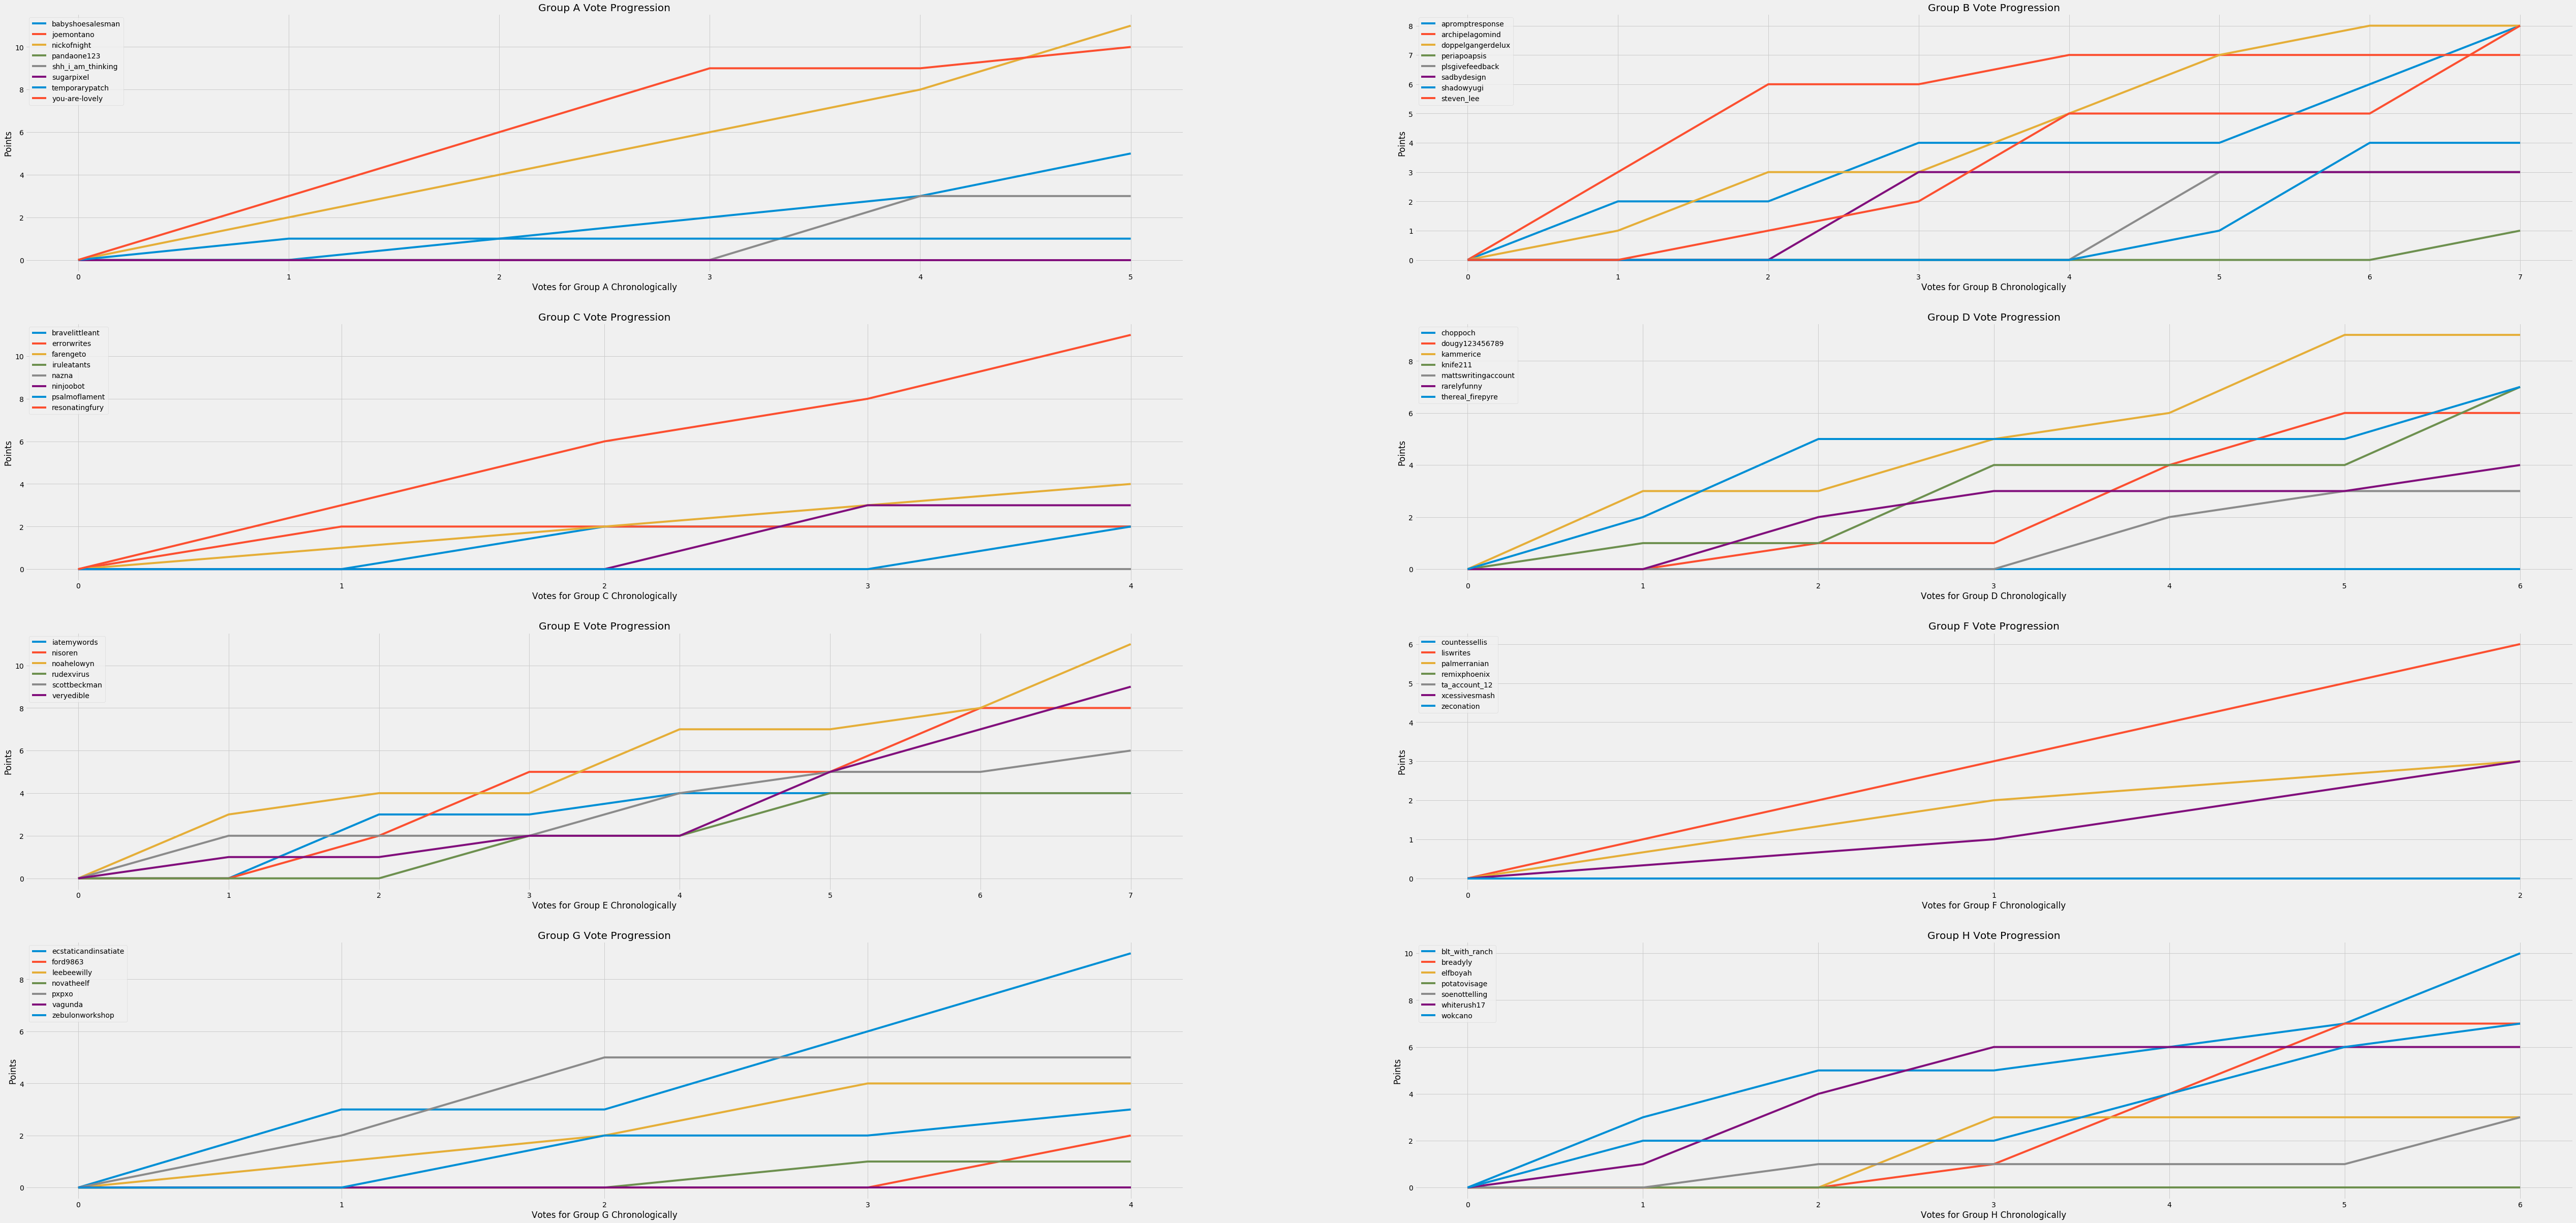

In [16]:
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use("fivethirtyeight")
fig = plt.figure(figsize=(80,40))
cnt = 1
for key, group in groups.items():
    ax = fig.add_subplot(4,2,cnt)
    cnt += 1
    for user in group.names:
        #print(user.name)
        plt.title("Group " + key + " Vote Progression")
        plt.plot(user.pointHist, label = user.name)
    plt.xlabel("Votes for Group " + key + " Chronologically")
    plt.ylabel("Points")
    plt.xticks(range(0, len(user.pointHist)))
    plt.legend()